# Jupyter Notebook Shortcuts

### Execution
* Execute cell, move to next cell: **Shift + Enter**
* Execute cell, stay on current cell: **Ctrl + Enter**

### Toggle Command/Edit Mode
* Edit Mode -> Command Mode: **Esc**
* Command Mode -> Edit Mode: **Enter**

### Command Mode
* Create cell ABOVE: **A**
* Create cell BELOW: **B**
* Delete cell: **D + D**
* Switch to Markdown: **M**
* Switch to Code: **Y**
* Toggle output show/hide: **O**

### Edit Mode
* Comment line: **Ctrl + /**
* Select all: **Ctrl + A**
* Undo: **Ctrl + Z**
* Redo: **Ctrl + Y**

# Setup

In [1]:
# General Packages
import sys
import sqlite3
import pandas as pd
import numpy as np
import time
import datetime
import copy
import warnings
import matplotlib
import matplotlib.pyplot as plt

# Modeling Packages
import sklearn
import fbprophet
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
import xgboost as xgb

# Jupyter settings
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)
warnings.simplefilter('ignore')

def disp(df, lines=5, type='head'):
    print(df.shape)
    if type == 'head':
        display(df.head(lines))
    elif type == 'tail':
        display(df.tail(lines))
    else:
        print("Error: Please enter either 'head' or 'tail'.")

class Clock:
    def __init__(self):
        self.start_time = 0
        
    def start(self):
        self.start_time = time.time()

    def stop(self):
        return round(time.time() - self.start_time, 5)
        
c = Clock()

# Import Raw Data

In [2]:
query_rides_a = '''
    SELECT *
    FROM rides_a
    LIMIT 100
'''

query_rides_b = '''
    SELECT *
    FROM rides_b
    LIMIT 100
'''

query_weather = '''
    SELECT *
    FROM weather
    LIMIT 100
'''

In [3]:
conn = sqlite3.connect('msda_workshop')
rides_a_df = pd.read_sql_query(query_rides_a, conn)
rides_b_df = pd.read_sql_query(query_rides_b, conn)
weather_df = pd.read_sql_query(query_weather, conn)
conn.close()

In [4]:
disp(rides_a_df)

(100, 21)


,RIDE_ID,started_on,created_date,updated_date,completed_on,distance_travelled,end_location_lat,end_location_long,driver_rating,rider_rating,active_driver_id,charity_id,requested_car_category,free_credit_used,surge_factor,start_location_long,start_location_lat,rider_id,round_up_amount,promocode_redemption_id,driver_reached_on
0,0,2016-06-04 00:18:49-05:00,2016-06-04 00:10:19-05:00,2016-06-04 00:27:48-05:00,2016-06-04 00:27:32-05:00,8459.0,38.676,-121.039,5.0,5.0,0,,b'REGULAR',,0.0,-121.071,38.655,0,,,2016-06-04 00:14:11-05:00
1,1,2016-06-04 01:50:12-05:00,2016-06-04 01:47:39-05:00,2016-06-04 01:52:00-05:00,2016-06-04 01:51:49-05:00,443.0,38.676,-121.039,5.0,5.0,0,,b'REGULAR',,0.0,-121.038,38.679,0,,,2016-06-04 01:50:02-05:00
2,2,2016-06-04 03:16:02-05:00,2016-06-04 03:13:07-05:00,2016-06-04 03:18:07-05:00,2016-06-04 03:17:57-05:00,568.0,38.676,-121.039,3.0,5.0,1,,b'REGULAR',,0.0,-121.042,38.678,0,,,2016-06-04 03:16:01-05:00
3,3,2016-06-04 10:05:13-05:00,2016-06-04 09:52:35-05:00,2016-06-04 10:14:00-05:00,2016-06-04 10:13:38-05:00,4051.0,30.271,-97.742,5.0,5.0,2,,b'REGULAR',,0.0,-97.764,30.247,1,,,2016-06-04 10:01:19-05:00
4,4,2016-06-04 10:24:25-05:00,2016-06-04 10:23:25-05:00,2016-06-04 10:26:16-05:00,2016-06-04 10:26:07-05:00,790.0,30.269,-97.752,5.0,5.0,2,,b'REGULAR',,0.0,-97.75,30.269,2,,,2016-06-04 10:24:15-05:00


In [5]:
disp(rides_b_df)

(100, 24)


,RIDE_ID,base_fare,total_fare,rate_per_mile,rate_per_minute,time_fare,driver_accepted_on,esimtated_time_arrive,tipped_on,tip,driving_time_to_rider,dispatch_location_lat,dispatch_location_long,driving_distance_to_rider,dispatched_on,status,driver_id,car_id,color,make,model,year,car_categories_bitmask,rating
0,0,1.5,25.84,1.5,0.25,2.18,,,,,,-121.039,-121.039,,2016-06-04 05:10:19,b'DISPATCHED',0,0,b'Gray',b'Bentley',b'Continental GT',b'2013',1,5.0
1,1,1.5,5.0,1.5,0.25,0.41,,,,,,-121.039,-121.039,,2016-06-04 06:47:39,b'DISPATCHED',0,0,b'Gray',b'Bentley',b'Continental GT',b'2013',1,5.0
2,2,1.5,5.0,1.5,0.25,0.48,,,,,,-121.039,-121.039,,2016-06-04 08:13:07,b'DISPATCHED',0,0,b'Gray',b'Bentley',b'Continental GT',b'2013',1,5.0
3,3,1.5,8.93,1.5,0.25,2.11,,,,,,-97.742,-97.742,,2016-06-04 14:52:35,b'DISPATCHED',1,1,b'Black',b'Cadillac',b'XTS',b'2013',21,5.0
4,4,1.5,5.0,1.5,0.25,0.43,,,,,,-97.752,-97.752,,2016-06-04 15:23:25,b'DISPATCHED',1,1,b'Black',b'Cadillac',b'XTS',b'2013',21,5.0


In [6]:
disp(weather_df)

(100, 16)


,RIDE_ID,HOURLYVISIBILITY,HOURLYDRYBULBTEMPC,HOURLYRelativeHumidity,HOURLYWindSpeed,HOURLYWindDirection,HOURLYPrecip,DAILYMaximumDryBulbTemp,DAILYMinimumDryBulbTemp,DAILYDeptFromNormalAverageTemp,DAILYAverageRelativeHumidity,DAILYSunrise,DAILYSunset,DAILYPrecip,DAILYAverageWindSpeed,DAILYPeakWindSpeed
0,0,8.75,20.700000000000003,94.0,6.0,13.333333333333334,0.0,,,,,529.0,1930.0,1.63,,
1,1,6.0,21.1,93.0,1.5,0.0,0.0,,,,,529.0,1930.0,,,
2,2,10.0,23.03333333333333,88.0,5.0,350.0,,,,,,529.0,1930.0,,,
3,3,10.0,26.7,64.0,11.0,360.0,0.0,,,,,529.0,1930.0,,,
4,4,10.0,26.7,64.0,11.0,360.0,0.0,,,,,529.0,1930.0,,,


# Initial Preprocessing Steps
* Join the three tables together
* Select only the columns we want
* Convert created_date from datetime to date
  * Original format: yyyy-mm-dd hh:mm:ss-hh:mm

In [3]:
c.start()

query_rides = '''
    SELECT
         a.RIDE_ID                      AS ride_id
        ,DATE(created_date)             AS date
        ,distance_travelled             AS distance
        ,start_location_lat             AS start_lat
        ,start_location_long            AS start_long
        ,end_location_lat               AS end_lat
        ,end_location_long              AS end_long
        ,round_up_amount                AS charity_amount
        ,status                         AS status
        ,requested_car_category         AS car_category
        ,make                           AS car_make
        ,model                          AS car_model
        ,HOURLYVISIBILITY               AS hourly_visibility
        ,HOURLYDRYBULBTEMPC             AS hourly_temp
        ,HOURLYRelativeHumidity         AS hourly_humidity
        ,HOURLYWindSpeed                AS hourly_wind_speed
        ,HOURLYWindDirection            AS hourly_wind_direction
        ,HOURLYPrecip                   AS hourly_precip
        ,DAILYMaximumDryBulbTemp        AS daily_temp_max
        ,DAILYMinimumDryBulbTemp        AS daily_temp_min
        ,DAILYDeptFromNormalAverageTemp AS daily_temp_departure
        ,DAILYAverageRelativeHumidity   AS daily_humidity
        ,DAILYSunrise                   AS daily_sunrise
        ,DAILYSunset                    AS daily_sunset
        ,DAILYPrecip                    AS daily_precip
        ,DAILYAverageWindSpeed          AS daily_wind_speed_avg
        ,DAILYPeakWindSpeed             AS daily_wind_spead_peak
    FROM rides_a a
        INNER JOIN rides_b b
            ON a.RIDE_ID = b.RIDE_ID
        INNER JOIN weather w
            ON a.RIDE_ID = w.RIDE_ID
    LIMIT 10000
'''

conn = sqlite3.connect('msda_workshop')
rides_df = pd.read_sql_query(query_rides, conn)
conn.close()

disp(rides_df)

c.stop()

(10000, 27)


,ride_id,date,distance,start_lat,start_long,end_lat,end_long,charity_amount,status,car_category,car_make,car_model,hourly_visibility,hourly_temp,hourly_humidity,hourly_wind_speed,hourly_wind_direction,hourly_precip,daily_temp_max,daily_temp_min,daily_temp_departure,daily_humidity,daily_sunrise,daily_sunset,daily_precip,daily_wind_speed_avg,daily_wind_spead_peak
0,0,2016-06-04,8459.0,38.655,-121.071,38.676,-121.039,,b'DISPATCHED',b'REGULAR',b'Bentley',b'Continental GT',8.75,20.700000000000003,94.0,6.0,13.333333333333334,0.0,,,,,529.0,1930.0,1.63,,
1,1,2016-06-04,443.0,38.679,-121.038,38.676,-121.039,,b'DISPATCHED',b'REGULAR',b'Bentley',b'Continental GT',6.0,21.1,93.0,1.5,0.0,0.0,,,,,529.0,1930.0,,,
2,2,2016-06-04,568.0,38.678,-121.042,38.676,-121.039,,b'DISPATCHED',b'REGULAR',b'Bentley',b'Continental GT',10.0,23.03333333333333,88.0,5.0,350.0,,,,,,529.0,1930.0,,,
3,3,2016-06-04,4051.0,30.247,-97.764,30.271,-97.742,,b'DISPATCHED',b'REGULAR',b'Cadillac',b'XTS',10.0,26.7,64.0,11.0,360.0,0.0,,,,,529.0,1930.0,,,
4,4,2016-06-04,790.0,30.269,-97.75,30.269,-97.752,,b'DISPATCHED',b'REGULAR',b'Cadillac',b'XTS',10.0,26.7,64.0,11.0,360.0,0.0,,,,,529.0,1930.0,,,


8.32635

# Inspect data further
* info
* columns
* unique
* value_counts

In [4]:
rides_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   ride_id                10000 non-null  object
 1   date                   10000 non-null  object
 2   distance               10000 non-null  object
 3   start_lat              10000 non-null  object
 4   start_long             10000 non-null  object
 5   end_lat                10000 non-null  object
 6   end_long               10000 non-null  object
 7   charity_amount         10000 non-null  object
 8   status                 10000 non-null  object
 9   car_category           10000 non-null  object
 10  car_make               10000 non-null  object
 11  car_model              10000 non-null  object
 12  hourly_visibility      10000 non-null  object
 13  hourly_temp            10000 non-null  object
 14  hourly_humidity        10000 non-null  object
 15  hourly_wind_speed   

In [6]:
rides_df.columns

Index(['ride_id', 'date', 'distance', 'start_lat', 'start_long', 'end_lat', 'end_long', 'charity_amount', 'status', 'car_category', 'car_make', 'car_model', 'hourly_visibility', 'hourly_temp', 'hourly_humidity', 'hourly_wind_speed', 'hourly_wind_direction', 'hourly_precip', 'daily_temp_max', 'daily_temp_min', 'daily_temp_departure', 'daily_humidity', 'daily_sunrise', 'daily_sunset', 'daily_precip', 'daily_wind_speed_avg', 'daily_wind_spead_peak'], dtype='object')

In [7]:
rides_df['car_category'].unique()

array(["b'REGULAR'", "b'PREMIUM'", "b'SUV'"], dtype=object)

In [8]:
rides_df['car_category'].value_counts()

b'REGULAR'    9816
b'SUV'         107
b'PREMIUM'      77
Name: car_category, dtype: int64

# Preprocessing

In [14]:
# Turn empty strings to NULLs
null_cols = [col for col in rides_df.columns if 'daily' in col]
for col in null_cols:
    rides_df.loc[rides_df[col] == '', col] = np.nan

In [15]:
disp(rides_df)

(10000, 27)


,ride_id,date,distance,start_lat,start_long,end_lat,end_long,charity_amount,status,car_category,car_make,car_model,hourly_visibility,hourly_temp,hourly_humidity,hourly_wind_speed,hourly_wind_direction,hourly_precip,daily_temp_max,daily_temp_min,daily_temp_departure,daily_humidity,daily_sunrise,daily_sunset,daily_precip,daily_wind_speed_avg,daily_wind_spead_peak
0,0,2016-06-04,8459.0,38.655,-121.071,38.676,-121.039,,b'DISPATCHED',b'REGULAR',b'Bentley',b'Continental GT',8.75,20.700000000000003,94.0,6.0,13.333333333333334,0.0,NaN,NaN,NaN,NaN,529.0,1930.0,1.63,NaN,NaN
1,1,2016-06-04,443.0,38.679,-121.038,38.676,-121.039,,b'DISPATCHED',b'REGULAR',b'Bentley',b'Continental GT',6.0,21.1,93.0,1.5,0.0,0.0,NaN,NaN,NaN,NaN,529.0,1930.0,NaN,NaN,NaN
2,2,2016-06-04,568.0,38.678,-121.042,38.676,-121.039,,b'DISPATCHED',b'REGULAR',b'Bentley',b'Continental GT',10.0,23.03333333333333,88.0,5.0,350.0,,NaN,NaN,NaN,NaN,529.0,1930.0,NaN,NaN,NaN
3,3,2016-06-04,4051.0,30.247,-97.764,30.271,-97.742,,b'DISPATCHED',b'REGULAR',b'Cadillac',b'XTS',10.0,26.7,64.0,11.0,360.0,0.0,NaN,NaN,NaN,NaN,529.0,1930.0,NaN,NaN,NaN
4,4,2016-06-04,790.0,30.269,-97.75,30.269,-97.752,,b'DISPATCHED',b'REGULAR',b'Cadillac',b'XTS',10.0,26.7,64.0,11.0,360.0,0.0,NaN,NaN,NaN,NaN,529.0,1930.0,NaN,NaN,NaN


In [16]:
rides_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   ride_id                10000 non-null  object
 1   date                   10000 non-null  object
 2   distance               10000 non-null  object
 3   start_lat              10000 non-null  object
 4   start_long             10000 non-null  object
 5   end_lat                10000 non-null  object
 6   end_long               10000 non-null  object
 7   charity_amount         10000 non-null  object
 8   status                 10000 non-null  object
 9   car_category           10000 non-null  object
 10  car_make               10000 non-null  object
 11  car_model              10000 non-null  object
 12  hourly_visibility      10000 non-null  object
 13  hourly_temp            10000 non-null  object
 14  hourly_humidity        10000 non-null  object
 15  hourly_wind_speed   

# Next Preprocessing Steps
* Need to aggregate hourly weather data, instead of using daily versions
    * Select and rename desired columns for ride-level data
    * Create hourly weather data by de-duplicating rides data
    * Aggregate from hourly-level to daily-level
    * Join back to rides on date
* Grab hour from created_date field (for use in first CTE)
* Select sensible agg functions for hourly -> daily weather fields

In [8]:
c.start()

query = '''
    WITH rides AS (
        SELECT
             a.RIDE_ID                      AS ride_id
            ,DATE(created_date)             AS date
            ,SUBSTR(created_date, 11, 2)    AS hour
            ,distance_travelled             AS distance
            ,start_location_lat             AS start_lat
            ,start_location_long            AS start_long
            ,end_location_lat               AS end_lat
            ,end_location_long              AS end_long
            ,round_up_amount                AS charity_amount
            ,status                         AS status
            ,requested_car_category         AS car_category
            ,make                           AS car_make
            ,model                          AS car_model
            ,HOURLYVISIBILITY               AS hourly_visibility
            ,HOURLYDRYBULBTEMPC             AS hourly_temp
            ,HOURLYRelativeHumidity         AS hourly_humidity
            ,HOURLYWindSpeed                AS hourly_wind_speed
            ,HOURLYWindDirection            AS hourly_wind_direction
            ,HOURLYPrecip                   AS hourly_precip
        FROM rides_a a
            INNER JOIN rides_b b
                ON a.RIDE_ID = b.RIDE_ID
            INNER JOIN weather w
                ON a.RIDE_ID = w.RIDE_ID
    ),
    -- NOTE:
    -- This will only contain weather for hours in which a ride occurred.
    hourly_weather AS (
        SELECT
             date
            ,hour
            ,MAX(hourly_visibility) AS visibility
            ,MAX(hourly_temp) AS temp
            ,MAX(hourly_humidity) AS humidity
            ,MAX(hourly_wind_speed) AS wind_speed
            ,MAX(hourly_wind_direction) AS wind_direction
            ,MAX(hourly_precip) AS precip
        FROM rides
        GROUP BY date, hour
    ),
    daily_weather AS (
        SELECT
             date
            ,AVG(visibility) AS visibility
            ,MAX(temp)       AS temp_max
            ,MIN(temp)       AS temp_min
            ,AVG(humidity)   AS humidity
            ,AVG(wind_speed) AS wind_speed
            ,SUM(precip)     AS precip
        FROM hourly_weather
        GROUP BY date
    )
    SELECT
         r.ride_id
        ,r.date
        ,r.distance
        ,r.charity_amount
        ,dw.visibility    AS daily_visibility
        ,dw.temp_max      AS daily_temp_max
        ,dw.temp_min      AS daily_temp_min
        ,dw.humidity      AS daily_humidity
        ,dw.wind_speed    AS daily_wind_speed
        ,dw.precip        AS daily_precip
    FROM rides r
        INNER JOIN daily_weather dw
            ON r.date = dw.date
'''

conn = sqlite3.connect('msda_workshop')
rides_df = pd.read_sql_query(query, conn)
conn.close()

disp(rides_df)

c.stop()

(1494125, 10)


,ride_id,date,distance,charity_amount,daily_visibility,daily_temp_max,daily_temp_min,daily_humidity,daily_wind_speed,daily_precip
0,0,2016-06-04,8459.0,,9.375,26.7,26.7,79.0,8.5,0.0
1,1,2016-06-04,443.0,,9.375,26.7,26.7,79.0,8.5,0.0
2,2,2016-06-04,568.0,,9.375,26.7,26.7,79.0,8.5,0.0
3,3,2016-06-04,4051.0,,9.375,26.7,26.7,79.0,8.5,0.0
4,4,2016-06-04,790.0,,9.375,26.7,26.7,79.0,8.5,0.0


46.54597

In [9]:
rides_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1494125 entries, 0 to 1494124
Data columns (total 10 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   ride_id           1494125 non-null  object 
 1   date              1494125 non-null  object 
 2   distance          1494125 non-null  object 
 3   charity_amount    1494125 non-null  object 
 4   daily_visibility  1494125 non-null  float64
 5   daily_temp_max    1494125 non-null  object 
 6   daily_temp_min    1494125 non-null  object 
 7   daily_humidity    1494125 non-null  float64
 8   daily_wind_speed  1494125 non-null  float64
 9   daily_precip      1494125 non-null  float64
dtypes: float64(4), object(6)
memory usage: 114.0+ MB


In [10]:
rides_df['date'][0]

'2016-06-04'

In [18]:
rides_df['charity_amount'].replace('', '0').astype(float).unique()

array([0.  , 0.31, 0.74, 0.75, 0.03, 0.28, 0.04, 0.07, 0.66, 0.93, 0.95,
       0.79, 0.29, 0.88, 0.25, 0.98, 0.47, 0.43, 0.17, 0.37, 0.91, 0.65,
       0.64, 0.99, 0.26, 0.59, 0.11, 0.15, 0.1 , 0.01, 0.58, 0.24, 0.18,
       0.71, 0.36, 0.02, 0.85, 0.78, 0.22, 0.82, 0.72, 0.4 , 0.41, 0.87,
       0.06, 0.44, 0.2 , 0.35, 0.14, 0.97, 0.6 , 0.56, 0.53, 0.62, 0.86,
       0.27, 0.7 , 0.84, 0.19, 0.81, 0.13, 0.23, 0.76, 0.89, 0.5 , 0.77,
       0.8 , 0.83, 0.16, 0.49, 0.92, 0.12, 0.9 , 0.39, 0.94, 0.42, 0.08,
       0.61, 0.45, 0.51, 0.33, 0.34, 0.46, 0.96, 0.48, 0.73, 0.57, 0.54,
       0.68, 0.05, 0.55, 0.67, 0.38, 0.52, 0.63, 0.32, 0.21, 0.09, 0.69,
       0.3 ])

# Column-specific preprocessing in Pandas
* **date**: string -> date
* **distance**: string -> float
* **charity_amount**: string -> float
* **daily_temp_max**: string -> float
* **daily_temp_min**: string -> float
* **temp columns**: celsius -> fahrenheit
    * write utility function for temp conversion

In [21]:
def celsius_to_fahrenheit(temp_c):
    temp_f = (temp_c * 1.8) + 32
    return temp_f

rides_df['date'] = pd.to_datetime(rides_df['date']).dt.date
rides_df['distance'] = rides_df['distance'].replace('', '0').astype(float)
rides_df['charity_amount'] = rides_df['charity_amount'].replace('', '0').astype(float)
rides_df['daily_temp_max'] = rides_df['daily_temp_max'].astype(float)
rides_df['daily_temp_min'] = rides_df['daily_temp_min'].astype(float)
rides_df['daily_temp_max_f'] = rides_df['daily_temp_max'].apply(celsius_to_fahrenheit)
rides_df['daily_temp_min_f'] = rides_df['daily_temp_min'].apply(celsius_to_fahrenheit)

# Use groupby to aggregate rides to daily-level data
* Choose specific agg functions
* Many ways to accomplish
    * Here we use .agg(col_name = ('column', 'function'))

In [23]:
days_df = rides_df.groupby(['date']).agg(
    rides = ('date', 'count'),
    distance = ('distance', 'sum'),
    charity_amount = ('charity_amount', 'sum'),
    visibility = ('daily_visibility', 'max'),
    temp_max = ('daily_temp_max_f', 'max'),
    temp_min = ('daily_temp_min_f', 'max'),
    humidity = ('daily_humidity', 'max'),
    wind_speed = ('daily_wind_speed', 'max'),
    precip = ('daily_precip', 'max')
).reset_index()

disp(days_df)

(314, 10)


,date,rides,distance,charity_amount,visibility,temp_max,temp_min,humidity,wind_speed,precip
0,2016-06-04,5,14311.0,0.0,9.375000,80.06,80.06,79.000000,8.500000,0.0
1,2016-06-05,13,75814.0,0.0,10.000000,77.00,69.98,77.666667,5.000000,0.0
2,2016-06-06,20,95260.0,0.0,10.000000,89.06,71.96,59.333333,6.333333,0.0
3,2016-06-07,21,154710.0,0.0,10.000000,91.04,69.98,70.666667,3.333333,0.0
4,2016-06-08,36,214613.0,0.0,9.666667,91.04,73.04,76.333333,5.000000,0.0


In [24]:
del rides_df

# Inspect data through plotting

<AxesSubplot:>

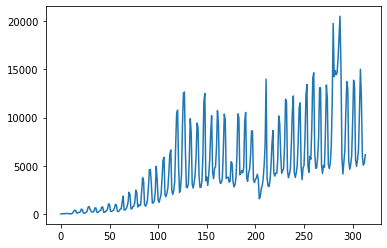

In [25]:
days_df['rides'].plot()

<AxesSubplot:>

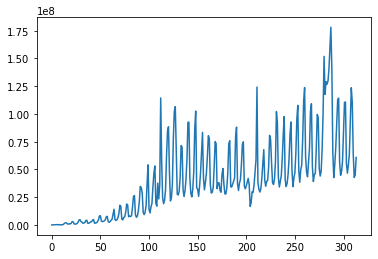

In [26]:
days_df['distance'].plot()

<AxesSubplot:>

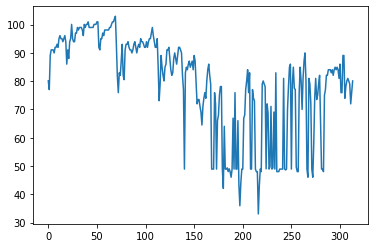

In [27]:
days_df['temp_max'].plot()

<AxesSubplot:>

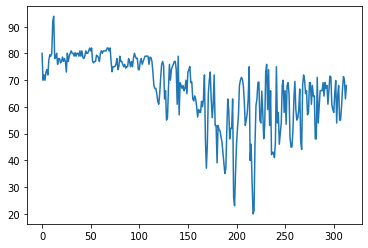

In [28]:
days_df['temp_min'].plot()

In [29]:
# f-strings can be very useful
print(f"Start Date: {days_df['date'].min()}")
print(f"End Date: {days_df['date'].max()}")

Start Date: 2016-06-04
End Date: 2017-04-13


# Add some preprocessing steps to SQL code (final query)
* Add car_category
    * Combine 'PREMIUM' and 'LUXURY'
    * Remove 'HONDA'
* Add status
    * Only select 'DISPATCHED' (remove 'DECLINED')

In [30]:
c.start()

query = '''
    WITH rides AS (
        SELECT
             a.RIDE_ID                                      AS ride_id
            ,DATE(created_date)                             AS date
            ,SUBSTR(created_date, 11, 2)                    AS hour
            ,distance_travelled                             AS distance
            ,start_location_lat                             AS start_lat
            ,start_location_long                            AS start_long
            ,end_location_lat                               AS end_lat
            ,end_location_long                              AS end_long
            ,round_up_amount                                AS charity_amount
            ,(CASE
                WHEN requested_car_category = "b'LUXURY'"
                    THEN "b'PREMIUM'"
                ELSE requested_car_category
              END)                                          AS car_category
            ,make                                           AS car_make
            ,model                                          AS car_model
            ,HOURLYVISIBILITY                               AS hourly_visibility
            ,HOURLYDRYBULBTEMPC                             AS hourly_temp
            ,HOURLYRelativeHumidity                         AS hourly_humidity
            ,HOURLYWindSpeed                                AS hourly_wind_speed
            ,HOURLYWindDirection                            AS hourly_wind_direction
            ,HOURLYPrecip                                   AS hourly_precip
        FROM rides_a a
            INNER JOIN rides_b b
                ON a.RIDE_ID = b.RIDE_ID
            INNER JOIN weather w
                ON a.RIDE_ID = w.RIDE_ID
        WHERE requested_car_category <> "b'HONDA'"
            AND status = "b'DISPATCHED'"
    ),
    -- NOTE:
    -- This will only contain weather for hours in which a ride occurred.
    hourly_weather AS (
        SELECT
             date
            ,hour
            ,MAX(hourly_visibility) AS visibility
            ,MAX(hourly_temp) AS temp
            ,MAX(hourly_humidity) AS humidity
            ,MAX(hourly_wind_speed) AS wind_speed
            ,MAX(hourly_wind_direction) AS wind_direction
            ,MAX(hourly_precip) AS precip
        FROM rides
        GROUP BY date, hour
    ),
    daily_weather AS (
        SELECT
             date
            ,AVG(visibility) AS visibility
            ,MAX(temp)       AS temp_max
            ,MIN(temp)       AS temp_min
            ,AVG(humidity)   AS humidity
            ,AVG(wind_speed) AS wind_speed
            ,SUM(precip)     AS precip
        FROM hourly_weather
        GROUP BY date
    )
    SELECT
         r.ride_id
        ,r.date
        ,r.car_category
        ,r.distance
        ,r.charity_amount
        ,dw.visibility    AS daily_visibility
        ,dw.temp_max      AS daily_temp_max
        ,dw.temp_min      AS daily_temp_min
        ,dw.humidity      AS daily_humidity
        ,dw.wind_speed    AS daily_wind_speed
        ,dw.precip        AS daily_precip
    FROM rides r
        INNER JOIN daily_weather dw
            ON r.date = dw.date
'''

conn = sqlite3.connect('msda_workshop')
rides_df = pd.read_sql_query(query, conn)
conn.close()

disp(rides_df)

c.stop()

(1044157, 11)


,ride_id,date,car_category,distance,charity_amount,daily_visibility,daily_temp_max,daily_temp_min,daily_humidity,daily_wind_speed,daily_precip
0,0,2016-06-04,b'REGULAR',8459.0,,9.375,26.7,26.7,79.0,8.5,0.0
1,1,2016-06-04,b'REGULAR',443.0,,9.375,26.7,26.7,79.0,8.5,0.0
2,2,2016-06-04,b'REGULAR',568.0,,9.375,26.7,26.7,79.0,8.5,0.0
3,3,2016-06-04,b'REGULAR',4051.0,,9.375,26.7,26.7,79.0,8.5,0.0
4,4,2016-06-04,b'REGULAR',790.0,,9.375,26.7,26.7,79.0,8.5,0.0


39.83207

# Condense all preprocessing steps and create a function
* Utility functions for temp conversion and string cleanup
* Data type conversions
* Grouping to date-level
* Data scaffold (to fill in date gaps for each car_category
    * Find all combinations of date and car_category
    * Left join from combinations to df on both columns
    * Create weather_df and join back to days_df to fill in gaps
        * Gaps created when car_category had no rides on particular day
    * Fill null values

In [32]:
def celsius_to_fahrenheit(temp_c):
    temp_f = (temp_c * 1.8) + 32
    return temp_f

def clean_b_string(string):
    start = 2
    end = len(string) - 1
    clean_string = string[start:end]
    return clean_string

def preprocess_df(df_orig):
    df = df_orig.copy()
    df['date'] = pd.to_datetime(df['date']).dt.date
    df['car_category'] = df['car_category'].apply(clean_b_string)
    df['distance'] = df['distance'].replace('', '0').astype(float)
    df['charity_amount'] = df['charity_amount'].replace('', '0').astype(float)
    df['daily_temp_max'] = df['daily_temp_max'].astype(float)
    df['daily_temp_min'] = df['daily_temp_min'].astype(float)
    df['daily_temp_max_f'] = df['daily_temp_max'].apply(celsius_to_fahrenheit)
    df['daily_temp_min_f'] = df['daily_temp_min'].apply(celsius_to_fahrenheit)
    
    days_df = df.groupby(['date', 'car_category']).agg(
        rides = ('date', 'count'),
        distance = ('distance', 'sum'),
        charity_amount = ('charity_amount', 'sum'),
        visibility = ('daily_visibility', 'max'),
        temp_max = ('daily_temp_max', 'max'),
        temp_min = ('daily_temp_min', 'max'),
        humidity = ('daily_humidity', 'max'),
        wind_speed = ('daily_wind_speed', 'max'),
        precip = ('daily_precip', 'max')
    ).reset_index()
    
    scaffold = pd.DataFrame(columns=['car_category', 'date'])

    for cat in days_df['car_category'].unique():
        start = days_df.loc[days_df['car_category'] == cat, 'date'].min()
        end = days_df.loc[days_df['car_category'] == cat, 'date'].max()
        scaffold_cat = pd.DataFrame({'car_category': cat, 'date': pd.date_range(start, end)})
        scaffold = pd.concat([scaffold, scaffold_cat]).reset_index(drop=True)
    
    scaffold['date'] = scaffold['date'].dt.date
    days_df = scaffold.merge(days_df, on=['car_category', 'date'], how='left')
    
    weather_df = days_df.groupby(['date']).agg(
        visibility = ('visibility', 'max'),
        temp_max = ('temp_max', 'max'),
        temp_min = ('temp_min', 'max'),
        humidity = ('humidity', 'max'),
        wind_speed = ('wind_speed', 'max'),
        precip = ('precip', 'max')
    ).reset_index()
    
    days_df_final = days_df[['car_category', 'date', 'rides', 'distance', 'charity_amount']]
    days_df_final = days_df_final.merge(weather_df, on='date', how='inner')
    fill_na_cols = ['rides', 'distance', 'charity_amount']
    days_df_final[fill_na_cols] = days_df_final[fill_na_cols].fillna(0)
    
    return days_df_final

In [33]:
df = preprocess_df(rides_df)

disp(df)

(886, 11)


,car_category,date,rides,distance,charity_amount,visibility,temp_max,temp_min,humidity,wind_speed,precip
0,REGULAR,2016-06-04,5.0,14311.0,0.0,9.375000,26.7,26.7,79.000000,8.500000,0.0
1,REGULAR,2016-06-05,5.0,29552.0,0.0,10.000000,23.3,20.0,76.666667,4.666667,0.0
2,REGULAR,2016-06-06,13.0,63948.0,0.0,10.000000,31.7,22.2,55.333333,6.000000,0.0
3,REGULAR,2016-06-07,10.0,97444.0,0.0,10.000000,32.8,21.1,70.666667,2.666667,0.0
4,REGULAR,2016-06-08,23.0,141151.0,0.0,9.666667,32.8,22.8,76.333333,4.666667,0.0


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 886 entries, 0 to 885
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   car_category    886 non-null    object 
 1   date            886 non-null    object 
 2   rides           886 non-null    float64
 3   distance        886 non-null    float64
 4   charity_amount  886 non-null    float64
 5   visibility      886 non-null    float64
 6   temp_max        886 non-null    float64
 7   temp_min        886 non-null    float64
 8   humidity        886 non-null    float64
 9   wind_speed      886 non-null    float64
 10  precip          886 non-null    float64
dtypes: float64(9), object(2)
memory usage: 83.1+ KB


# We will split data by car_category and forecast individually

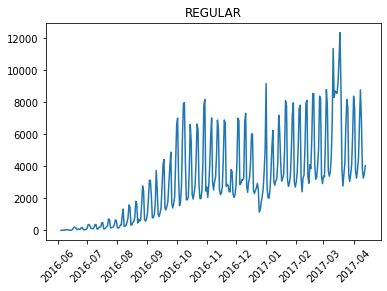

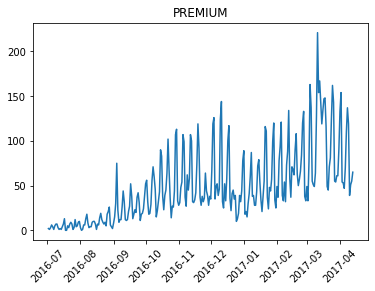

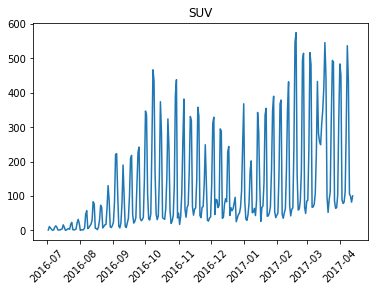

In [37]:
for cat in df['car_category'].unique():
    df_cat = df[df['car_category'] == cat]
    fig, ax = plt.subplots()
    plt.plot(df_cat['date'], df_cat['rides'])
    plt.title(cat)
    ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator())
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%Y-%m"))
    plt.xticks(rotation=45)
    plt.show()

# Forecasting

### Reduce to 1 category, univariate

In [6]:
prophet_df = df[df['car_category'] == 'REGULAR'][['date', 'rides']].rename(columns={'date': 'ds', 'rides': 'y'})

disp(prophet_df)

(314, 2)


,ds,y
0,2016-06-04,5.0
1,2016-06-05,5.0
2,2016-06-06,13.0
3,2016-06-07,10.0
4,2016-06-08,23.0


### Create a Prophet model
* Initialized with some standard parameters
    * growth = 'linear' versus 'logistic'
    * seasonality_mode = 'multiplicative' versus 'additive'
* Daily Data --> Weekly & Monthly Seasonality
* No Yearly Seasonality, since data spans < 1 year
* Standard built-in holidays (US)

In [11]:
# Initialize model
m = Prophet(growth='linear', seasonality_mode='multiplicative', weekly_seasonality=True)
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
m.add_country_holidays(country_name='US')
holiday_cols = ['Christmas Day', 'Christmas Day (Observed)', 'Columbus Day', 'Independence Day', 'Labor Day', 
                'Martin Luther King Jr. Day', 'Memorial Day', "New Year's Day", "New Year's Day (Observed)", 'Thanksgiving', 'Veterans Day', 
                'Veterans Day (Observed)', "Washington's Birthday"]

### Fit model and forecast future
* Forecasting horizon set to 30 days
* Plot results (built-in Prophet functionality)
* Print holiday effects for inspection

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Christmas Day                 1.119505
New Year's Day                0.712999
Columbus Day                  0.404734
Christmas Day (Observed)      0.238185
Labor Day                     0.132516
Martin Luther King Jr. Day    0.120104
New Year's Day (Observed)     0.077341
Thanksgiving                  0.070765
Washington's Birthday         0.065032
Veterans Day                  0.052816
Independence Day              0.001529
Veterans Day (Observed)       0.000000
Memorial Day                  0.000000
dtype: float64


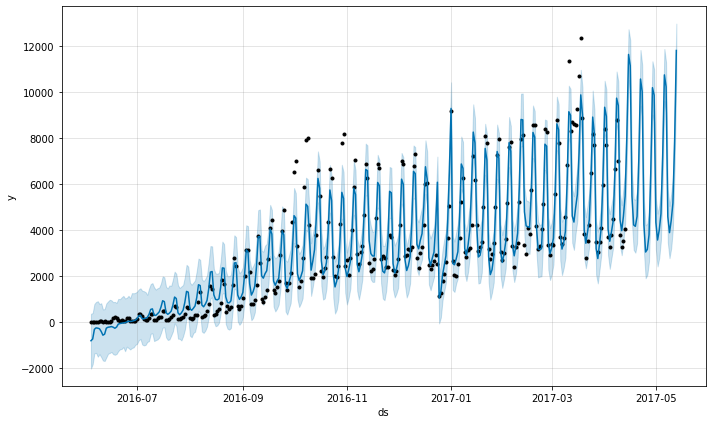

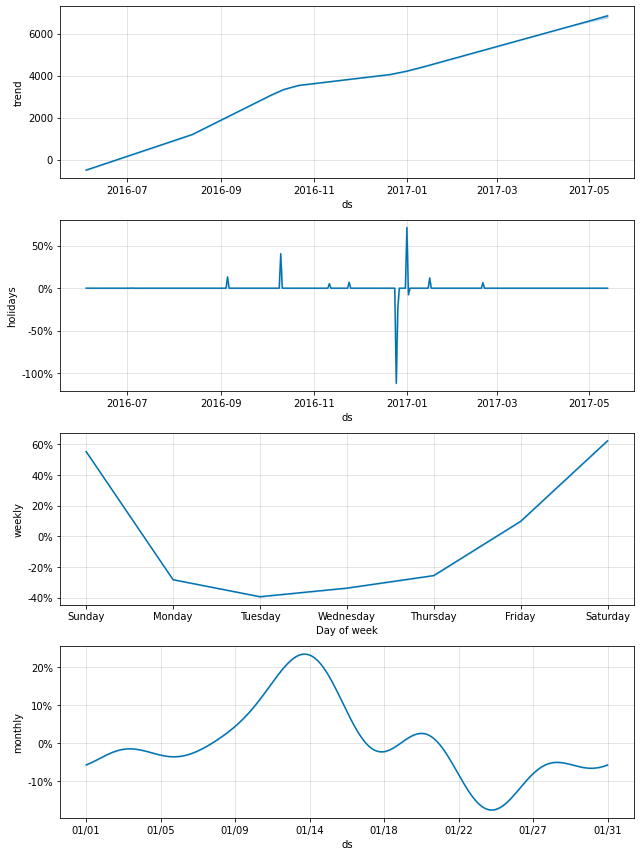

In [12]:
horizon = 30
m.fit(prophet_df)
future = m.make_future_dataframe(periods=horizon, freq='D')
pred = m.predict(future)

fig = m.plot(pred);
m.plot_components(pred);
print(abs(pred[holiday_cols]).max().sort_values(ascending=False));


### Prophet cross validation (60-day test period)
* View performance metrics across this test period
    * mse = Mean Squared Error
    * rmse = Root Mean Squared Error
    * mae = Mean Absolute Error
    * mape = Mean Absolute Percent Error
    * mdape = Median Absolute Percent Error
    * coverage = Confidence Interval Coverage

In [9]:
df_cv = cross_validation(m, initial='253 days', horizon = '60 days')

disp(df_cv)

INFO:fbprophet:Making 1 forecasts with cutoffs between 2017-02-12 00:00:00 and 2017-02-12 00:00:00



(60, 6)


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2017-02-13,3076.496005,2346.661003,3808.478417,3368.0,2017-02-12
1,2017-02-14,2553.998181,1854.849328,3267.347155,2944.0,2017-02-12
2,2017-02-15,2741.507982,2032.194011,3429.037346,4105.0,2017-02-12
3,2017-02-16,3124.974589,2406.757040,3779.315882,3853.0,2017-02-12
4,2017-02-17,4832.419162,4094.707410,5576.997359,5751.0,2017-02-12


In [10]:
df_p = performance_metrics(df_cv)

df_p.tail(1)

,horizon,mse,rmse,mae,mape,mdape,coverage
54,60 days,1.104222e+06,1050.819462,589.89529,0.101919,0.067846,0.833333


### Add regressors to Prophet model
* Features native to target variable called "endogenous variables"
* External features called "exogenous variables"
* Use each weather feature as regressor (exogenous)
* "future" dataframe must also include regressor values

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Christmas Day                 0.286588
Labor Day                     0.225342
New Year's Day                0.190520
Martin Luther King Jr. Day    0.151802
Veterans Day                  0.095725
Columbus Day                  0.087903
Washington's Birthday         0.057396
Christmas Day (Observed)      0.043117
Independence Day              0.030991
Thanksgiving                  0.019342
New Year's Day (Observed)     0.010858
Veterans Day (Observed)       0.000000
Memorial Day                  0.000000
dtype: float64


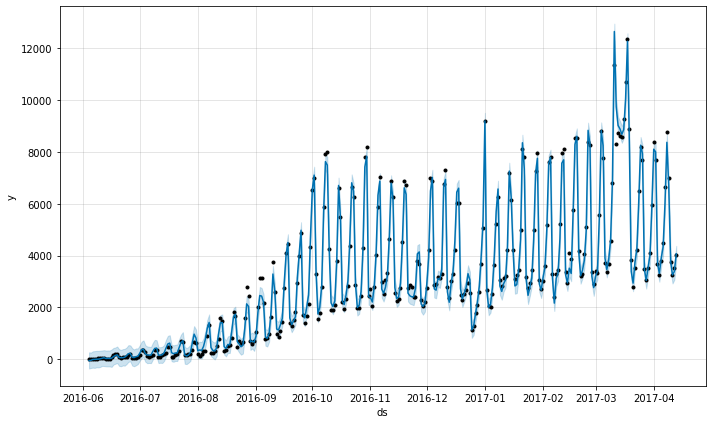

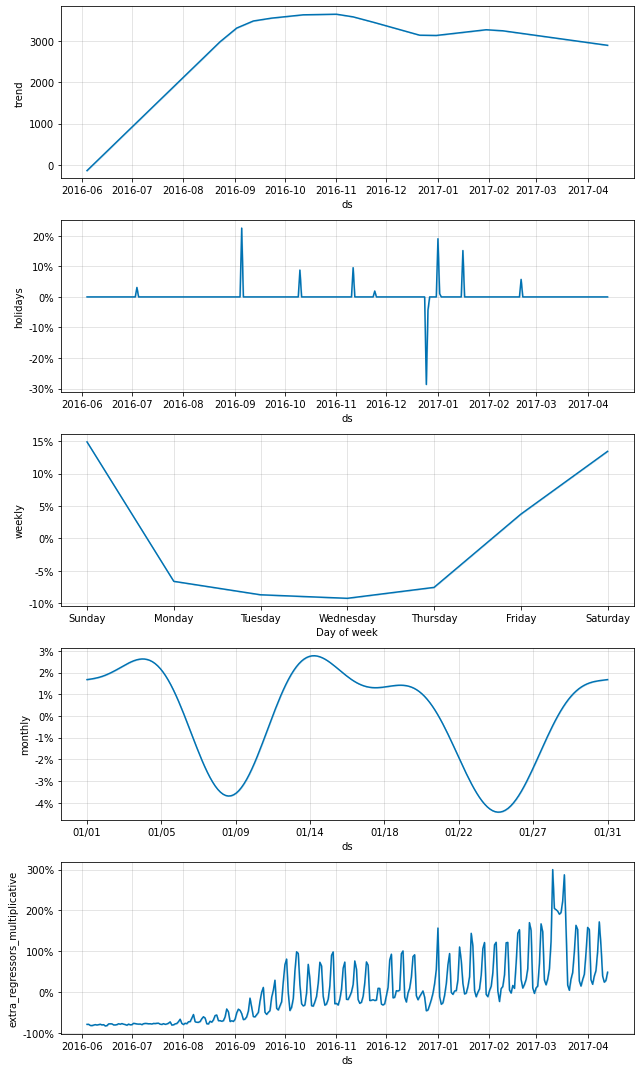

In [13]:
# Create df
prophet_df = df[df['car_category'] == 'REGULAR'].rename(columns={'date': 'ds', 'rides': 'y'}).drop(['car_category', 'distance'], axis=1)
X = prophet_df.drop(['ds', 'y'], axis=1)

# Initialize model
m = Prophet(growth='linear', seasonality_mode='multiplicative', weekly_seasonality=True)
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
m.add_country_holidays(country_name='US')
holiday_cols = ['Christmas Day', 'Christmas Day (Observed)', 'Columbus Day', 'Independence Day', 'Labor Day', 
                'Martin Luther King Jr. Day', 'Memorial Day', "New Year's Day", "New Year's Day (Observed)", 'Thanksgiving', 'Veterans Day', 
                'Veterans Day (Observed)', "Washington's Birthday"]

# Add regressors
for col in X:
    m.add_regressor(col)

# Fit model
horizon = 30
m.fit(prophet_df)

# Create future dataframe
future = m.make_future_dataframe(periods=horizon, freq='D')
future['ds'] = future['ds'].dt.date
future = future.merge(prophet_df.drop('y', axis=1), on='ds', how='inner')

# Predict
pred = m.predict(future)

# Output
fig = m.plot(pred);
m.plot_components(pred);
print(abs(pred[holiday_cols]).max().sort_values(ascending=False));

### Try cross validation again, with regressors
* Highly dependent on test period
* In this case, for 60-day period, model performed "better" without regressors

In [14]:
df_cv = cross_validation(m, initial='253 days', horizon = '60 days')
df_p = performance_metrics(df_cv)

df_p.tail(1)

INFO:fbprophet:Making 1 forecasts with cutoffs between 2017-02-12 00:00:00 and 2017-02-12 00:00:00


,horizon,mse,rmse,mae,mape,mdape,coverage
54,60 days,2.704302e+06,1644.476271,1608.483589,0.340763,0.360992,0.0


In [15]:
disp(df_cv)

(60, 6)


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2017-02-13,3337.101578,3126.966736,3557.153334,3368.0,2017-02-12
1,2017-02-14,3153.178393,2942.110609,3378.295688,2944.0,2017-02-12
2,2017-02-15,3706.766511,3456.458469,3932.060129,4105.0,2017-02-12
3,2017-02-16,3473.866928,3241.325382,3717.027884,3853.0,2017-02-12
4,2017-02-17,5920.939867,5682.614089,6149.882362,5751.0,2017-02-12


# Walk-Forward Evaluation
* Often a preferred evaluation method for time series model (compared to something like 60-day holdout period)
* Simulates the actual use of model in business - building model on all existing data and forecasting the next day's value
* Also called "1-step ahead" evaluation
* Steps (ex. data contains 100 days):
    * Choose a testing period (ex. 20 days)
    * Train model on 100 - 20 = 80 days, forecast only 81st day
    * Store forecast and actual value for Day 81
    * Re-train model on 81 days, forecast only 82nd day
    * Store forecast and actual value for Day 82
    * Rinse and repeat until all data exhausted
    * Compare predictions with actuals using standard performance metrics

### Model Eval Functions

In [7]:
def root_mean_squared_error(y_true, y_pred):
    result = np.sqrt(np.mean((y_true - y_pred) ** 2))
    return np.round(result, 3)

def mean_forecast_error(y_true, y_pred):
    result = np.mean(y_true - y_pred)
    return np.round(result, 20)

def mean_absolute_error(y_true, y_pred):
    result = np.mean(np.abs(y_true - y_pred))
    return np.round(result, 3)

def mean_absolute_percentage_error(y_true, y_pred, zero_method='adjust', adj=0.1):
    if zero_method == 'adjust':
        y_true_adj = y_true.copy()
        y_true_adj[y_true_adj == 0] = adj
        result = np.mean(np.abs((y_true_adj - y_pred) / y_true_adj)) * 100

    elif zero_method == 'error':
        if len(y_true[y_true == 0]) > 0:
            raise ValueError('Input y_true array contains a zero.')
        else:
            result = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    elif zero_method == 'ignore':
        y_true_ign = y_true.copy()
        y_true_ign = y_true_ign[y_true_ign != 0]
        result = np.mean(np.abs((y_true_ign - y_pred) / y_true_ign)) * 100

    else:
        raise ValueError("Invalid zero_method value - must be 'adjust', 'error', or 'ignore'.")

    return np.round(result, 3)

### Functions used for Walk Forward Evaluation
* add_endog_vars
    * Endogenous variables are native to target variable itself
    * Lag = Previous day's "rides" value
    * Diff = Difference between current and previous days' "rides" values
    * Lag Diff = Difference between prior two days' "rides" values
    * Day of Week = Numbers 0-6, to enforce weekly seasonality (not built in to XGBoost)
* train_prophet
    * Input data and model, fit Prophet repeatedly, return 1-day forecasts
* train_non_prophet
    * Same functionality as train_prophet
    * Built to handle standard sklearn-type models (like the XGBoost regressor)
* walk_forward_evaluation
    * Wrapper function that calls appropriate training function and displays results
* fit_forecasters
    * Wrapper function that repeats evaluation process for each desired model

In [8]:
def add_endog_vars(df, day_of_week=False):
    # Simple lag and difference for y
    df['y_lag_1'] = df['y'].shift(1)
    df['y_lag_diff_1'] = df['y_lag_1'].diff(1)

    # Add day of week, if needed
    # Day 0 = Monday
    if day_of_week:
        df['day_of_week'] = pd.to_datetime(df['ds']).dt.dayofweek
        df = pd.get_dummies(df, prefix='day_', columns=['day_of_week'])
    
    # Remove rows without full data
    df = df.dropna(0).reset_index(drop=True)

    return df


def train_prophet(df, model, date_list):
    df = add_endog_vars(df)
    X = df.drop(['ds', 'y'], axis=1)
    y_pred_list = []
    horizon = 1

    for d in date_list:
        print(f'Fitting model to forecast {d}')

        model_copy = copy.copy(model)
        for col in X:
            model_copy.add_regressor(col)

        # Split train and test
        idx = df[df['ds'] == d].index[0]
        train, test = df[0:idx], df[idx:(idx + horizon)].drop('y', axis=1)

        # Fit and predict
        try:
            model_copy.fit(train)
            pred = model_copy.predict(test)
            y_pred_list.append(pred['yhat'])
        except:
            print(f'Error fitting model for {d}')
            sys.exit()

    return y_pred_list


def train_non_prophet(df, model, date_list):
    df = add_endog_vars(df, day_of_week=True)
    y = df['y']
    X = df.drop(['ds', 'y'], axis=1)
    y_pred_list = []
    horizon = 1

    for d in date_list:
        print(f'Fitting model to forecast {d}')

        # Split train and test
        idx = df[df['ds'] == d].index[0]
        y_train, X_train = y[0:idx], X[0:idx]
        y_test, X_test = y[idx:(idx + horizon)], X[idx:(idx + horizon)]

        # Fit and predict
        try:
            model.fit(X_train, y_train)
            pred = model.predict(X_test)[0]
            y_pred_list.append(pred)
        except:
            print(f'Error fitting model for {d}')
            sys.exit()

    return y_pred_list


def walk_forward_evaluation(df, model, first_test_day, plot_title):
    # Set up for daily evaluation
    date_list = list(pd.Series(pd.date_range(start=first_test_day, end=df['ds'].max())).dt.date)

    if isinstance(model, fbprophet.forecaster.Prophet):
        y_pred = train_prophet(df, model, date_list)
    else:
        y_pred = train_non_prophet(df, model, date_list)

    # Create results df
    test_df = df[df['ds'] >= first_test_day]
    results = pd.DataFrame({'ds': test_df['ds'], 'actual': test_df['y'], 'pred': y_pred})

    # Plot results
    plt.plot(results['actual'])
    plt.plot(results['pred'], 'r--', alpha=0.8)
    plt.legend(['Actual GMR', 'Predicted GMR'])
    plt.title(plot_title)
    plt.show()

    # Accuracy
    metrics_dict = {}
    metrics_dict['mape'] = mean_absolute_percentage_error(results['actual'], results['pred'])
    metrics_dict['rmse'] = root_mean_squared_error(results['actual'], results['pred'])
    metrics_dict['mae'] = mean_absolute_error(results['actual'], results['pred'])
    metrics_dict['mfe'] = mean_forecast_error(results['actual'], results['pred'])

    return results, metrics_dict


def fit_forecasters(df, model_dict, first_test_day):
    for model_name in model_dict.keys():
        c.start()
        print(f'Fitting {model_name}')
        model = model_dict[model_name]['model']
        plot_title = model_dict[model_name]['label']

        results, metrics = walk_forward_evaluation(df, model, first_test_day, plot_title)
        model_dict[model_name]['results'] = results
        model_dict[model_name]['metrics'] = metrics
        c.stop()

### Test Walk Forward Evaluation Process
* Modify dataframe to simplify before feeding into model
* Define model and testing start date
* Run evaluation

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting model to forecast 2017-03-14


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting model to forecast 2017-03-15


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting model to forecast 2017-03-16


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting model to forecast 2017-03-17


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting model to forecast 2017-03-18


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting model to forecast 2017-03-19


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting model to forecast 2017-03-20


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting model to forecast 2017-03-21


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting model to forecast 2017-03-22


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting model to forecast 2017-03-23


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting model to forecast 2017-03-24


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting model to forecast 2017-03-25


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting model to forecast 2017-03-26


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting model to forecast 2017-03-27


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting model to forecast 2017-03-28


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting model to forecast 2017-03-29


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting model to forecast 2017-03-30


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting model to forecast 2017-03-31


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting model to forecast 2017-04-01


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting model to forecast 2017-04-02


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting model to forecast 2017-04-03


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting model to forecast 2017-04-04


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting model to forecast 2017-04-05


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting model to forecast 2017-04-06


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting model to forecast 2017-04-07


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting model to forecast 2017-04-08


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting model to forecast 2017-04-09


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting model to forecast 2017-04-10


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting model to forecast 2017-04-11


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting model to forecast 2017-04-12


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting model to forecast 2017-04-13


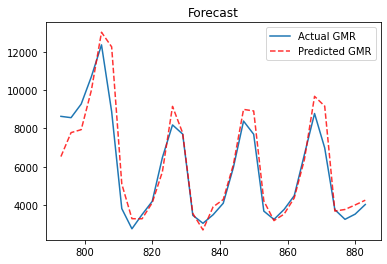

             ds   actual                                          pred
793  2017-03-14   8633.0   0    6538.419654
Name: yhat, dtype: float64
796  2017-03-15   8564.0   0    7785.707054
Name: yhat, dtype: float64
799  2017-03-16   9275.0   0    7939.384721
Name: yhat, dtype: float64
802  2017-03-17  10698.0   0    9987.096166
Name: yhat, dtype: float64
805  2017-03-18  12357.0  0    13013.911875
Name: yhat, dtype: float64
808  2017-03-19   8881.0  0    12253.222557
Name: yhat, dtype: float64
811  2017-03-20   3827.0   0    5108.548897
Name: yhat, dtype: float64
814  2017-03-21   2776.0    0    3302.00138
Name: yhat, dtype: float64
817  2017-03-22   3518.0   0    3296.650317
Name: yhat, dtype: float64
820  2017-03-23   4205.0   0    4132.796284
Name: yhat, dtype: float64
823  2017-03-24   6484.0   0    5740.975969
Name: yhat, dtype: float64
826  2017-03-25   8187.0   0    9151.743571
Name: yhat, dtype: float64
829  2017-03-26   7709.0   0    7763.597612
Name: yhat, dtype: float64
832  2

70.44596

In [15]:
c.start()

drop_cols = ['car_category', 'distance', 'charity_amount']
prophet_df = df[df['car_category'] == 'REGULAR'].rename(columns={'date': 'ds', 'rides': 'y'}).drop(drop_cols, axis=1)

model = Prophet(growth='linear', seasonality_mode='multiplicative', weekly_seasonality=True)
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model.add_country_holidays(country_name='US')
title = 'Forecast'
first_test_day = datetime.date(2017, 3, 14)
results, metrics = walk_forward_evaluation(prophet_df, model, first_test_day=first_test_day, plot_title=title)
print(results)
print(metrics)

c.stop()

### Try same process with XGBoost model
* XGBRegressor initialized with standard parameters (feel free to experiment on your own)

Fitting model to forecast 2017-03-14
Fitting model to forecast 2017-03-15
Fitting model to forecast 2017-03-16
Fitting model to forecast 2017-03-17
Fitting model to forecast 2017-03-18
Fitting model to forecast 2017-03-19
Fitting model to forecast 2017-03-20
Fitting model to forecast 2017-03-21
Fitting model to forecast 2017-03-22
Fitting model to forecast 2017-03-23
Fitting model to forecast 2017-03-24
Fitting model to forecast 2017-03-25
Fitting model to forecast 2017-03-26
Fitting model to forecast 2017-03-27
Fitting model to forecast 2017-03-28
Fitting model to forecast 2017-03-29
Fitting model to forecast 2017-03-30
Fitting model to forecast 2017-03-31
Fitting model to forecast 2017-04-01
Fitting model to forecast 2017-04-02
Fitting model to forecast 2017-04-03
Fitting model to forecast 2017-04-04
Fitting model to forecast 2017-04-05
Fitting model to forecast 2017-04-06
Fitting model to forecast 2017-04-07
Fitting model to forecast 2017-04-08
Fitting model to forecast 2017-04-09
F

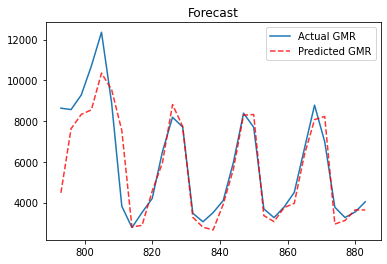

             ds   actual          pred
793  2017-03-14   8633.0   4479.540039
796  2017-03-15   8564.0   7621.997559
799  2017-03-16   9275.0   8325.447266
802  2017-03-17  10698.0   8548.661133
805  2017-03-18  12357.0  10352.397461
808  2017-03-19   8881.0   9539.533203
811  2017-03-20   3827.0   7541.676270
814  2017-03-21   2776.0   2804.074463
817  2017-03-22   3518.0   2887.752441
820  2017-03-23   4205.0   4568.493652
823  2017-03-24   6484.0   5946.568359
826  2017-03-25   8187.0   8810.169922
829  2017-03-26   7709.0   7739.857910
832  2017-03-27   3478.0   3281.147461
835  2017-03-28   3062.0   2792.467529
838  2017-03-29   3507.0   2660.950684
841  2017-03-30   4107.0   3921.232910
844  2017-03-31   5970.0   5637.145020
847  2017-04-01   8387.0   8291.029297
850  2017-04-02   7699.0   8319.560547
853  2017-04-03   3696.0   3362.795410
856  2017-04-04   3264.0   3070.920410
859  2017-04-05   3784.0   3755.561523
862  2017-04-06   4501.0   3963.690918
865  2017-04-07   6646.0 

32.29975

In [16]:
c.start()

drop_cols = ['car_category', 'distance', 'charity_amount']
xgb_df = df[df['car_category'] == 'REGULAR'].rename(columns={'date': 'ds', 'rides': 'y'}).drop(drop_cols, axis=1)

model = xgb.XGBRegressor(n_estimators=100, reg_lambda=1, gamma=0, max_depth=3)
title = 'Forecast'
first_test_day = datetime.date(2017, 3, 14)
results, metrics = walk_forward_evaluation(xgb_df, model, first_test_day, plot_title=title)
print(results)
print(metrics)

c.stop()

### Evaluate both models using a dictionary setup
* fit_forecasters function reads a model_dict object and runs evaluation for each model found therein
* Define/initialize both models, then store resulting model objects into dictionary
* Model objects will be extracted from dictionary and subsequently trained on data

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting prophet
Fitting model to forecast 2017-03-14


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting model to forecast 2017-03-15


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting model to forecast 2017-03-16


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting model to forecast 2017-03-17


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting model to forecast 2017-03-18


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting model to forecast 2017-03-19


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting model to forecast 2017-03-20


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting model to forecast 2017-03-21


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting model to forecast 2017-03-22


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting model to forecast 2017-03-23


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting model to forecast 2017-03-24


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting model to forecast 2017-03-25


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting model to forecast 2017-03-26


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting model to forecast 2017-03-27


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting model to forecast 2017-03-28


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting model to forecast 2017-03-29


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting model to forecast 2017-03-30


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting model to forecast 2017-03-31


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting model to forecast 2017-04-01


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting model to forecast 2017-04-02


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting model to forecast 2017-04-03


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting model to forecast 2017-04-04


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting model to forecast 2017-04-05


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting model to forecast 2017-04-06


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting model to forecast 2017-04-07


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting model to forecast 2017-04-08


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting model to forecast 2017-04-09


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting model to forecast 2017-04-10


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting model to forecast 2017-04-11


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting model to forecast 2017-04-12


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting model to forecast 2017-04-13


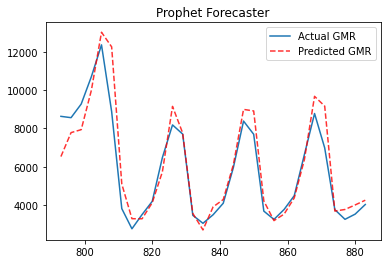

Fitting xgboost
Fitting model to forecast 2017-03-14
Fitting model to forecast 2017-03-15
Fitting model to forecast 2017-03-16
Fitting model to forecast 2017-03-17
Fitting model to forecast 2017-03-18
Fitting model to forecast 2017-03-19
Fitting model to forecast 2017-03-20
Fitting model to forecast 2017-03-21
Fitting model to forecast 2017-03-22
Fitting model to forecast 2017-03-23
Fitting model to forecast 2017-03-24
Fitting model to forecast 2017-03-25
Fitting model to forecast 2017-03-26
Fitting model to forecast 2017-03-27
Fitting model to forecast 2017-03-28
Fitting model to forecast 2017-03-29
Fitting model to forecast 2017-03-30
Fitting model to forecast 2017-03-31
Fitting model to forecast 2017-04-01
Fitting model to forecast 2017-04-02
Fitting model to forecast 2017-04-03
Fitting model to forecast 2017-04-04
Fitting model to forecast 2017-04-05
Fitting model to forecast 2017-04-06
Fitting model to forecast 2017-04-07
Fitting model to forecast 2017-04-08
Fitting model to forec

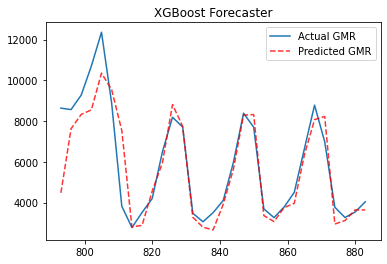

prophet
{'mape': 11.143, 'rmse': 1004.259, 'mae': 690.682, 'mfe': -235.21318667512054}
xgboost
{'mape': 13.195, 'rmse': 1243.261, 'mae': 778.987, 'mfe': 302.86040669102823}


In [17]:
# Create Prophet model
forecaster_prophet = Prophet(growth='linear', seasonality_mode='multiplicative', weekly_seasonality=True)
forecaster_prophet.add_seasonality(name='monthly', period=30.5, fourier_order=5)
forecaster_prophet.add_country_holidays(country_name='US')

# Create XGBoost model
forecaster_xgb = xgb.XGBRegressor(n_estimators=100, reg_lambda=1, gamma=0, max_depth=3)

# Create model dictionary for evaluation
model_dict = {
        'prophet': {
            'label': 'Prophet Forecaster',
            'model': forecaster_prophet,
            'results': None,
            'metrics': None
        },
        'xgboost': {
            'label': 'XGBoost Forecaster',
            'model': forecaster_xgb,
            'results': None,
            'metrics': None
        }
    }

# Run evaluation
first_test_day = datetime.date(2017, 3, 14)
drop_cols = ['car_category', 'distance', 'charity_amount']
input_df = df[df['car_category'] == 'REGULAR'].rename(columns={'date': 'ds', 'rides': 'y'}).drop(drop_cols, axis=1)
fit_forecasters(input_df, model_dict, first_test_day)

for model in model_dict.keys():
    print(model)
    print(model_dict[model]['metrics'])

In [18]:
for model in model_dict.keys():
    print(model)
    print(model_dict[model]['metrics'])

prophet
{'mape': 11.143, 'rmse': 1004.259, 'mae': 690.682, 'mfe': -235.21318667512054}
xgboost
{'mape': 13.195, 'rmse': 1243.261, 'mae': 778.987, 'mfe': 302.86040669102823}


# Write Production Version of Code

### Config

In [22]:
import datetime
train_cutoff = datetime.date(2017, 3, 14)
model_location = ''

### Utility Functions

In [23]:
class Clock:
    def __init__(self):
        self.start_time = 0
        
    def start(self):
        self.start_time = time.time()

    def stop(self):
        return round(time.time() - self.start_time, 5)
    

def disp(df, lines = 5, type='head'):
    print(df.shape)
    if type == 'head':
        display(df.head(lines))
    elif type == 'tail':
        display(df.tail(lines))
    else:
        print("Error: Please enter either 'head' or 'tail'.")

        
def root_mean_squared_error(y_true, y_pred):
    result = np.sqrt(np.mean((y_true - y_pred) ** 2))
    return np.round(result, 3)


def mean_forecast_error(y_true, y_pred):
    result = np.mean(y_true - y_pred)
    return np.round(result, 20)


def mean_absolute_error(y_true, y_pred):
    result = np.mean(np.abs(y_true - y_pred))
    return np.round(result, 3)


def mean_absolute_percentage_error(y_true, y_pred, zero_method='adjust', adj=0.1):
    if zero_method == 'adjust':
        y_true_adj = y_true.copy()
        y_true_adj[y_true_adj == 0] = adj
        result = np.mean(np.abs((y_true_adj - y_pred) / y_true_adj)) * 100

    elif zero_method == 'error':
        if len(y_true[y_true == 0]) > 0:
            raise ValueError('Input y_true array contains a zero.')
        else:
            result = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    elif zero_method == 'ignore':
        y_true_ign = y_true.copy()
        y_true_ign = y_true_ign[y_true_ign != 0]
        result = np.mean(np.abs((y_true_ign - y_pred) / y_true_ign)) * 100

    else:
        raise ValueError("Invalid zero_method value - must be 'adjust', 'error', or 'ignore'.")

    return np.round(result, 3)

### Queries

In [24]:
# from utils import *


c = Clock()

def get_ride_austin_data(filepath):
    c.start()
    query = '''
        WITH rides AS (
            SELECT
                 a.RIDE_ID                                      AS ride_id
                ,DATE(created_date)                             AS date
                ,SUBSTR(created_date, 11, 2)                    AS hour
                ,distance_travelled                             AS distance
                ,start_location_lat                             AS start_lat
                ,start_location_long                            AS start_long
                ,end_location_lat                               AS end_lat
                ,end_location_long                              AS end_long
                ,round_up_amount                                AS charity_amount
                ,(CASE
                    WHEN requested_car_category = "b'LUXURY'"
                        THEN "b'PREMIUM'"
                    ELSE requested_car_category
                  END)                                          AS car_category
                ,make                                           AS car_make
                ,model                                          AS car_model
                ,HOURLYVISIBILITY                               AS hourly_visibility
                ,HOURLYDRYBULBTEMPC                             AS hourly_temp
                ,HOURLYRelativeHumidity                         AS hourly_humidity
                ,HOURLYWindSpeed                                AS hourly_wind_speed
                ,HOURLYWindDirection                            AS hourly_wind_direction
                ,HOURLYPrecip                                   AS hourly_precip
            FROM rides_a a
                INNER JOIN rides_b b
                    ON a.RIDE_ID = b.RIDE_ID
                INNER JOIN weather w
                    ON a.RIDE_ID = w.RIDE_ID
            WHERE requested_car_category <> "b'HONDA'"
                AND status = "b'DISPATCHED'"
        ),
        -- NOTE:
        -- This will only contain weather for hours in which a ride occurred.
        hourly_weather AS (
            SELECT
                 date
                ,hour
                ,MAX(hourly_visibility) AS visibility
                ,MAX(hourly_temp) AS temp
                ,MAX(hourly_humidity) AS humidity
                ,MAX(hourly_wind_speed) AS wind_speed
                ,MAX(hourly_wind_direction) AS wind_direction
                ,MAX(hourly_precip) AS precip
            FROM rides
            GROUP BY date, hour
        ),
        daily_weather AS (
            SELECT
                 date
                ,AVG(visibility) AS visibility
                ,MAX(temp)       AS temp_max
                ,MIN(temp)       AS temp_min
                ,AVG(humidity)   AS humidity
                ,AVG(wind_speed) AS wind_speed
                ,SUM(precip)     AS precip
            FROM hourly_weather
            GROUP BY date
        )
        SELECT
             r.ride_id
            ,r.date
            ,r.car_category
            ,r.distance
            ,r.charity_amount
            ,dw.visibility    AS daily_visibility
            ,dw.temp_max      AS daily_temp_max
            ,dw.temp_min      AS daily_temp_min
            ,dw.humidity      AS daily_humidity
            ,dw.wind_speed    AS daily_wind_speed
            ,dw.precip        AS daily_precip
        FROM rides r
            INNER JOIN daily_weather dw
                ON r.date = dw.date
    '''
    conn = sqlite3.connect(filepath)
    df = pd.read_sql_query(query, conn)
    conn.close()
    et = c.stop()
    print(f'Imported Rides Data: {df.shape[0]} rows, {et} seconds')
    
    return df


### Preprocessing

In [25]:
def celsius_to_fahrenheit(temp_c):
    temp_f = (temp_c * 1.8) + 32
    return temp_f


def clean_b_string(string):
    start = 2
    end = len(string) - 1
    clean_string = string[start:end]
    return clean_string


def preprocess_df(df_orig):
    df = df_orig.copy()
    df['date'] = pd.to_datetime(df['date']).dt.date
    df['car_category'] = df['car_category'].apply(clean_b_string)
    df['distance'] = df['distance'].replace('', '0').astype(float)
    df['charity_amount'] = df['charity_amount'].replace('', '0').astype(float)
    df['daily_temp_max'] = df['daily_temp_max'].astype(float)
    df['daily_temp_min'] = df['daily_temp_min'].astype(float)
    df['daily_temp_max_f'] = df['daily_temp_max'].apply(celsius_to_fahrenheit)
    df['daily_temp_min_f'] = df['daily_temp_min'].apply(celsius_to_fahrenheit)
    
    days_df = df.groupby(['date', 'car_category']).agg(
        rides = ('date', 'count'),
        distance = ('distance', 'sum'),
        charity_amount = ('charity_amount', 'sum'),
        visibility = ('daily_visibility', 'max'),
        temp_max = ('daily_temp_max', 'max'),
        temp_min = ('daily_temp_min', 'max'),
        humidity = ('daily_humidity', 'max'),
        wind_speed = ('daily_wind_speed', 'max'),
        precip = ('daily_precip', 'max')
    ).reset_index()
    
    scaffold = pd.DataFrame(columns=['car_category', 'date'])

    for cat in days_df['car_category'].unique():
        start = days_df.loc[days_df['car_category'] == cat, 'date'].min()
        end = days_df.loc[days_df['car_category'] == cat, 'date'].max()
        scaffold_cat = pd.DataFrame({'car_category': cat, 'date': pd.date_range(start, end)})
        scaffold = pd.concat([scaffold, scaffold_cat]).reset_index(drop=True)
    
    scaffold['date'] = scaffold['date'].dt.date
    days_df = scaffold.merge(days_df, on=['car_category', 'date'], how='left')
    
    weather_df = days_df.groupby(['date']).agg(
        visibility = ('visibility', 'max'),
        temp_max = ('temp_max', 'max'),
        temp_min = ('temp_min', 'max'),
        humidity = ('humidity', 'max'),
        wind_speed = ('wind_speed', 'max'),
        precip = ('precip', 'max')
    ).reset_index()
    
    days_df_final = days_df[['car_category', 'date', 'rides', 'distance', 'charity_amount']]
    days_df_final = days_df_final.merge(weather_df, on='date', how='inner')
    fill_na_cols = ['rides', 'distance', 'charity_amount']
    days_df_final[fill_na_cols] = days_df_final[fill_na_cols].fillna(0)
    
    return days_df_final


### NOTE:
# This function reduces the data to our chosen target variable and car_category
# Modify/eliminate this function if you decide to experiment with other forecasts
def prepare_df_msda_workshop(df):
    drop_cols = ['car_category', 'distance', 'charity_amount']
    input_df = df[df['car_category'] == 'REGULAR'].rename(columns={'date': 'ds', 'rides': 'y'}).drop(drop_cols, axis=1)
    
    return input_df


def add_endog_vars(df, day_of_week=False):
    # Simple lag and difference for y
    df['y_lag_1'] = df['y'].shift(1)
    df['y_lag_diff_1'] = df['y_lag_1'].diff(1)

    # Add day of week, if needed
    # Day 0 = Monday
    if day_of_week:
        df['day_of_week'] = pd.to_datetime(df['ds']).dt.dayofweek
        df = pd.get_dummies(df, prefix='day_', columns=['day_of_week'])
    
    # Remove rows without full data
    df = df.dropna(0).reset_index(drop=True)

    return df


def train_test(df, train_cutoff):
    idx = df[df['ds'] == train_cutoff].index[0]
    train, test = df[0:idx], df[idx:]
    return train, test

### Model Build

In [26]:
def train_prophet(train_df, model_location):
    c.start()
    X = train_df.drop(['ds', 'y'], axis=1)

    model = Prophet(growth='linear', seasonality_mode='multiplicative', weekly_seasonality=True)
    model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
    model.add_country_holidays(country_name='US')

    for col in X:
        model.add_regressor(col)

    # Fit and predict
    model.fit(train_df)
#     with open(model_location, 'w') as file_out:
#         json.dump(model_to_json(model), file_out)

    print(f'Prophet model fitted: {c.stop()} seconds')
    
    return model


def train_xgb(train_df, model_location):
    c.start()
    y = train_df['y']
    X = train_df.drop(['ds', 'y'], axis=1)

    model = xgb.XGBRegressor(n_estimators=100, reg_lambda=1, gamma=0, max_depth=3)
    
    # Fit and predict
    model.fit(X, y)
#     with open(model_location, 'wb') as file_out:
#         pickle.dump(model, file_out)

    print(f'XGBoost model fitted: {c.stop()} seconds')
    
    return model


### Forecasting

In [27]:
def load_prophet(model_location):
    with open(model_location, 'r') as file_in:
        model = model_from_json(json.load(file_in))
    
    return model


def load_xgb(model_location):
    with open(model_location, 'rb') as file_in:
        model = pickle.load(file_in)
    
    return model


def forecast_prophet(fcst_df, model):
    pred_df = model.predict(fcst_df.drop('y', axis=1))
    pred_df['ds'] = pred_df['ds'].dt.date
    
    return pred_df
    

def forecast_xgb(fcst_df, model):
    pred = model.predict(fcst_df.drop(['ds', 'y'], axis=1))
    pred_df = pd.DataFrame({'yhat': pred})
    
    return pred_df
    
    

### Main

In [28]:
# External Packages
import sys
import sqlite3
import pandas as pd
import numpy as np
import time
import datetime
import copy
import warnings
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import json
import pickle
import fbprophet
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.serialize import model_to_json, model_from_json
import xgboost as xgb

# Internal Modules
# from config import *


rides_df = get_ride_austin_data(filepath='msda_workshop')
df = preprocess_df(rides_df)
df = prepare_df_msda_workshop(df)

# Build Prophet Model
prophet_df = add_endog_vars(df)
prophet_df_train, prophet_df_test = train_test(prophet_df, train_cutoff)
model_prophet = train_prophet(prophet_df_train, model_location)

# Forecast with Prophet
# model_prophet = load_prophet(model_location)
pred_df_prophet = forecast_prophet(prophet_df_test, model_prophet)
pred_df_p = prophet_df_test[['ds', 'y']].merge(pred_df_prophet[['ds', 'yhat']], on='ds', how='inner')

# Build XGBoost Model
xgb_df = add_endog_vars(df, day_of_week=True)
xgb_df_train, xgb_df_test = train_test(xgb_df, train_cutoff)
model_xgb = train_xgb(xgb_df_train, model_location)

# Forecast with XGBoost
# model_xgb = load_xgb(model_location)
pred_xgb = forecast_xgb(xgb_df_test, model_xgb)
pred_df_x = pd.concat([xgb_df_test[['ds', 'y']].reset_index(drop=True), pred_xgb], axis=1)

# Combine into single prediction output
pred_df = pred_df_p.merge(pred_df_x[['ds', 'yhat']], on='ds', how='inner').rename(columns={'yhat_x': 'pred_prophet', 'yhat_y': 'pred_xgb'})



Imported Rides Data: 1044157 rows, 25.38256 seconds


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Prophet model fitted: 0.28832 seconds
XGBoost model fitted: 0.75728 seconds


In [29]:
pred_df

,ds,y,pred_prophet,pred_xgb
0,2017-03-14,8633.0,6538.419654,4479.540039
1,2017-03-15,8564.0,7616.943101,5704.710449
2,2017-03-16,9275.0,7728.673511,5729.391602
3,2017-03-17,10698.0,9444.365805,6357.449219
4,2017-03-18,12357.0,12386.922506,9118.049805
5,2017-03-19,8881.0,11895.128434,7519.412598
6,2017-03-20,3827.0,5572.002051,5721.151367
7,2017-03-21,2776.0,3634.564552,2457.455566
8,2017-03-22,3518.0,3466.591505,2789.568848
9,2017-03-23,4205.0,4019.665769,3733.963135


In [30]:
def display_results(pred_df, pred_col):
    # Plot results
    plt.plot(pred_df['y'])
    plt.plot(pred_df[pred_col], 'r--', alpha=0.8)
    plt.legend(['Actual', 'Predicted'])
    plt.title('Ride Austin Forecast')
    plt.show()

    # Accuracy
    metrics_dict = {}
    metrics_dict['mape'] = mean_absolute_percentage_error(pred_df['y'], pred_df[pred_col])
    metrics_dict['rmse'] = root_mean_squared_error(pred_df['y'], pred_df[pred_col])
    metrics_dict['mae'] = mean_absolute_error(pred_df['y'], pred_df[pred_col])
    metrics_dict['mfe'] = mean_forecast_error(pred_df['y'], pred_df[pred_col])
    
    print(metrics_dict)

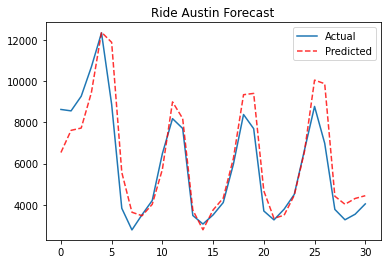

{'mape': 14.249, 'rmse': 1144.886, 'mae': 837.022, 'mfe': -350.95226470649783}


In [31]:
display_results(pred_df, 'pred_prophet')

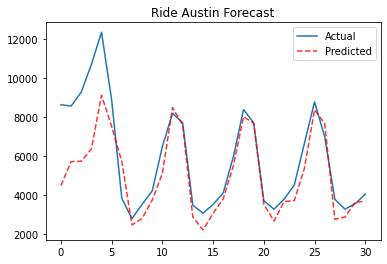

{'mape': 17.073, 'rmse': 1627.36, 'mae': 1089.03, 'mfe': 898.8258489793346}


In [32]:
display_results(pred_df, 'pred_xgb')

### See forecasting package in GitHub for final version